# Predicting Adoption Speed

## Introduction

The purpose of this notebook is to provide an analysis of which types of pets have the toughest time getting adopted. In this analysis we are only studying the adoptions of Dogs and cats.

## Business Understanding

Shelters need to know which pets take the longest time to get adopted, so that they can focus on pushing potential adopters towards those pets.

+ __Stakeholder:__ ASPCA 


+ __Importance of Predictions:__ Correctly identifying which pets will have trouble getting adopted can save pets from a lifetime in a cage or getting put to sleep in the worst case scenario.


+ __Deliverable:__ An analysis of the adoptability of different types of dogs and cats


+ __Type of model:__ An interpretable multiclassification model that can be used in conjunction with domain knowledge to boost the accuracy of predictions on a pet's adoptability.

## Context

+ __False Positive:__ Predicting that a pet will get adopted sooner than it actually gets adopted


+ __False negative:__ Predicting that a pet will get adopted later than it actually gets adopted


+ __Which is Worse:__ False negative is worse because we would not correctly identify pets that need help getting adopted in a timely manner


+ __

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 
import warnings

warnings.filterwarnings('ignore')

## Data Understanding

- I cleaned most of the data in the EDA notebook and that data is also included in this repository
- Most of the pets in this dataset have been adopted, thats why the focus is on adoption speed
- The target variable is 'duration of stay' which will be divided into 4 categories

These imports are saved csv files that I made after extensively cleaning the data in the EDA notebook.

In [2]:
cat_df = pd.read_csv('data/cat_df.csv')
dog_df = pd.read_csv('data/dog_df.csv')

## Data Exploration recap

In [4]:
cat_df['sexname'].value_counts()

Female     3598
Male       3341
Unknown     133
Name: sexname, dtype: int64

In [5]:
dog_df['sexname'].value_counts()

Male       2454
Female     1996
Unknown      20
Name: sexname, dtype: int64

The sex of both dogs and cats are pretty balanced

In [6]:
cat_df['age(months)'].value_counts()

6.0    201
1.0    162
3.0    112
2.0     79
4.0     65
5.0     58
Name: age(months), dtype: int64

In [7]:
dog_df['age(months)'].value_counts()

5.0    29
6.0    27
4.0    12
1.0     9
3.0     2
2.0     2
Name: age(months), dtype: int64

Not many puppies in this dataset, but we have almost 600 kittens.

In [8]:
cat_df['age(years)'].value_counts()

1.0     2580
2.0     1256
3.0     1052
0.0      677
4.0      390
5.0      269
6.0      171
7.0      160
8.0      116
10.0      96
9.0       61
11.0      57
12.0      45
13.0      39
14.0      30
15.0      26
16.0      26
17.0      12
18.0       6
19.0       3
Name: age(years), dtype: int64

In [9]:
dog_df['age(years)'].value_counts()

1.0     982
2.0     728
3.0     644
4.0     445
5.0     293
6.0     205
8.0     180
7.0     180
9.0     145
11.0    123
10.0    120
12.0    103
0.0      81
14.0     78
13.0     77
15.0     38
16.0     30
17.0      8
18.0      8
19.0      2
Name: age(years), dtype: int64

Most of the pets in this dataset are on the younger side of the scale.

### Prepare Dog Data for modeling

In [10]:
dog_df.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,12,46238,2016-10-09 00:00:00,Abandoned,False,981020019070093,Tennessee,Heeler,Black and Brown,Dog,5 years 7 months,Male,Special Care Dogs,2018-02-14 00:00:00,Adoption,NaN,False,NaN,5.0,493.0
1,15,46693,2016-11-21 00:00:00,Abandoned,False,981020017897009,Baby,Pitbull,White,Dog,5 years 9 months,Male,Adoptable Dogs,2017-04-07 00:00:00,Adoption,NaN,False,NaN,5.0,137.0
2,19,47146,2017-01-17 00:00:00,Abandoned,False,981020021063793,Dinah,Labrador Retriever,Black,Dog,5 years 6 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,5.0,74.0
3,27,47239,2017-01-27 00:00:00,Abandoned,False,981020021070452,Maria,NaN,Black and Brown,Dog,3 years 5 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,3.0,64.0
4,33,47319,2017-02-05 00:00:00,other,False,NaN,Louise Vada,Pitbull,Black,Dog,4 years 5 months,Female,Stray Dogs Theta,2017-04-05 00:00:00,Reclaimed,NaN,False,NaN,4.0,59.0


In [11]:
dog_df['age(months)'].describe()

count    81.000000
mean      4.617284
std       1.569776
min       1.000000
25%       4.000000
50%       5.000000
75%       6.000000
max       6.000000
Name: age(months), dtype: float64

In [12]:
dog_df['movementtype'].value_counts()

Adoption     2841
Reclaimed    1487
Transfer      107
Foster         34
Escaped         1
Name: movementtype, dtype: int64

This model is gonna focus on the dogs that got adopted, and predict how long it takes 

In [13]:
dog_model_data = dog_df[dog_df['movementtype'] == 'Adoption']

In [14]:
dog_model_data['duration of stay'].isna().sum()

0

In [15]:
dog_model_data.describe()

,Unnamed: 0,id,age(months),age(years),duration of stay
count,2841.000000,2841.000000,65.000000,2841.000000,2841.000000
mean,8698.644843,62603.009152,5.061538,3.689194,53.449490
std,5244.246966,4842.666952,0.899252,3.221766,118.125138
min,12.000000,46238.000000,2.000000,0.000000,1.000000
25%,4123.000000,58835.000000,5.000000,1.000000,10.000000
50%,8203.000000,62340.000000,5.000000,3.000000,18.000000
75%,12722.000000,66193.000000,6.000000,5.000000,41.000000
max,18667.000000,71690.000000,6.000000,18.000000,1443.000000


Now I want to categorize my target column into these 4 values.

- 0 — Pet was adopted between 1 and 7 days (1st week) after being listed.
- 1 — Pet was adopted between 8 and 30 days (1st month) after being listed.
- 2 — Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 3 — No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [16]:
dog_model_data['duration of stay'][dog_model_data['duration of stay'] <= 7] = 0
dog_model_data['duration of stay'][(dog_model_data['duration of stay'] > 7) & (dog_model_data['duration of stay'] <= 30)] = 1
dog_model_data['duration of stay'][(dog_model_data['duration of stay'] > 30) & (dog_model_data['duration of stay'] <= 90)] = 2
dog_model_data['duration of stay'][dog_model_data['duration of stay'] > 90] = 3

In [17]:
dog_model_data['duration of stay'].value_counts()

1.0    1463
2.0     608
0.0     447
3.0     323
Name: duration of stay, dtype: int64

In [18]:
 dog_model_data.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,12,46238,2016-10-09 00:00:00,Abandoned,False,981020019070093,Tennessee,Heeler,Black and Brown,Dog,5 years 7 months,Male,Special Care Dogs,2018-02-14 00:00:00,Adoption,NaN,False,NaN,5.0,3.0
1,15,46693,2016-11-21 00:00:00,Abandoned,False,981020017897009,Baby,Pitbull,White,Dog,5 years 9 months,Male,Adoptable Dogs,2017-04-07 00:00:00,Adoption,NaN,False,NaN,5.0,3.0
2,19,47146,2017-01-17 00:00:00,Abandoned,False,981020021063793,Dinah,Labrador Retriever,Black,Dog,5 years 6 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,5.0,2.0
3,27,47239,2017-01-27 00:00:00,Abandoned,False,981020021070452,Maria,NaN,Black and Brown,Dog,3 years 5 months,Female,Foster,2017-04-01 00:00:00,Adoption,NaN,False,NaN,3.0,2.0
7,50,47502,2017-02-27 00:00:00,other,False,981020015101070,Zoey,Pitbull,Grey and White,Dog,5 years 4 months,Female,Stray Dogs Beta,2017-06-01 00:00:00,Adoption,NaN,False,NaN,5.0,3.0


In [19]:
dog_model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2841 entries, 0 to 4467
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2841 non-null   int64  
 1   id                2841 non-null   int64  
 2   intakedate        2841 non-null   object 
 3   intakereason      2841 non-null   object 
 4   istransfer        2841 non-null   bool   
 5   identichipnumber  2838 non-null   object 
 6   animalname        2841 non-null   object 
 7   breedname         2840 non-null   object 
 8   basecolour        2841 non-null   object 
 9   speciesname       2841 non-null   object 
 10  animalage         2841 non-null   object 
 11  sexname           2841 non-null   object 
 12  location          2841 non-null   object 
 13  movementdate      2841 non-null   object 
 14  movementtype      2841 non-null   object 
 15  returndate        55 non-null     object 
 16  puttosleep        2841 non-null   bool   


Breedname is missing one value so i will fill it with 'Other'

In [20]:
dog_model_data['breedname'] = dog_model_data['breedname'].fillna('Other')

The months that have missing values means that age will be dictated by the years column, so we can fill the rest of the months column with zeroes, I did the same thing for the years column in my data cleaning notebook before saving the csv. Will be more organized in final notebook.

In [21]:
dog_model_data['age(months)'] = dog_model_data['age(months)'].fillna(0)

### Prepare Cat data for Modeling

In [22]:
cat_df.head()

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
0,14,46437,2016-10-26 00:00:00,Abandoned,False,981020017650993,Nova,Domestic Long Hair,Black,Cat,12 years 3 months,Female,Stray Cats,2017-04-07 00:00:00,Adoption,02/09/2018 12:00:00 AM,True,NaN,12.0,163.0
1,17,47120,2017-01-11 00:00:00,Abandoned,False,981020021072899,Vivian,Other,Other,Cat,6 years 5 months,Female,Foster,2017-05-13 00:00:00,Adoption,NaN,False,NaN,6.0,122.0
2,26,47198,2017-01-22 00:00:00,Abandoned,False,981020021020775,Mama Mia,Domestic Short Hair,Grey and White,Cat,4 years 10 months,Female,Adoptable Cat Glass Colony,2017-06-22 00:00:00,Adoption,NaN,False,NaN,4.0,151.0
3,29,47248,2017-01-27 00:00:00,Abandoned,False,981020021068759,Mr. T,Other,Black,Cat,11 years 7 months,Male,Foster,2017-06-02 00:00:00,Adoption,NaN,False,NaN,11.0,126.0
4,30,47277,2017-01-31 00:00:00,Abandoned,False,981020021046006,Coraline,Domestic Short Hair,Brown and Black,Cat,5 years 5 months,Female,Adoptable Cat Glass Colony,2017-04-05 00:00:00,Adoption,NaN,False,NaN,5.0,64.0


In [23]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7072 entries, 0 to 7071
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7072 non-null   int64  
 1   id                7072 non-null   int64  
 2   intakedate        7072 non-null   object 
 3   intakereason      7072 non-null   object 
 4   istransfer        7072 non-null   bool   
 5   identichipnumber  6170 non-null   object 
 6   animalname        7072 non-null   object 
 7   breedname         7072 non-null   object 
 8   basecolour        7072 non-null   object 
 9   speciesname       7072 non-null   object 
 10  animalage         7072 non-null   object 
 11  sexname           7072 non-null   object 
 12  location          7072 non-null   object 
 13  movementdate      7072 non-null   object 
 14  movementtype      7072 non-null   object 
 15  returndate        200 non-null    object 
 16  puttosleep        7072 non-null   bool   


In [24]:
cat_df['breedname'].value_counts()

Domestic Short Hair     5811
Domestic Medium Hair     560
Domestic Long Hair       419
Siamese                  121
Manx                      52
Other                     47
Unknown                   29
Bengal                    11
Maine Coon                 9
Oriental Shorthair         7
Calico                     6
Name: breedname, dtype: int64

In [25]:
cat_df['movementtype'].value_counts()

Adoption            5945
Reclaimed            405
Transfer             356
Foster               326
Released To Wild      29
Stolen                 6
Escaped                5
Name: movementtype, dtype: int64

In [26]:
cat_df[cat_df['movementtype'] =='Foster'].head(30)

,Unnamed: 0,id,intakedate,intakereason,istransfer,identichipnumber,animalname,breedname,basecolour,speciesname,animalage,sexname,location,movementdate,movementtype,returndate,puttosleep,age(months),age(years),duration of stay
6,36,47360,2017-02-11 00:00:00,Abandoned,False,981020021060759,Calli,Domestic Short Hair,Other,Cat,16 years 3 months,Female,Office,2017-06-12 00:00:00,Foster,06/13/2017 12:00:00 AM,True,NaN,16.0,121.0
63,313,55371,2017-04-03 16:30:55,Abandoned,False,NaN,Ronan,Calico,Other,Cat,1 months,Female,Feline Nursery,2017-04-18 00:00:00,Foster,08/25/2017 12:00:00 AM,False,1.0,0.0,15.0
77,344,55396,2017-03-18 00:00:00,Abandoned,False,NaN,Gray,Domestic Short Hair,Grey and White,Cat,1 months,Female,Foster,2017-03-20 00:00:00,Foster,04/11/2017 12:00:00 AM,False,1.0,0.0,2.0
78,345,55397,2017-03-18 00:00:00,Abandoned,False,NaN,Brown,Domestic Short Hair,Brown and Black,Cat,1 months,Female,Foster,2017-03-20 00:00:00,Foster,04/11/2017 12:00:00 AM,False,1.0,0.0,2.0
79,346,55398,2017-03-18 00:00:00,Abandoned,False,NaN,White,Domestic Short Hair,Black and White,Cat,1 months,Female,Foster,2017-03-20 00:00:00,Foster,04/11/2017 12:00:00 AM,False,1.0,0.0,2.0
80,347,55399,2017-03-18 00:00:00,Abandoned,False,NaN,Black,Domestic Short Hair,Black and White,Cat,1 months,Female,Foster,2017-03-20 00:00:00,Foster,04/02/2017 12:00:00 AM,False,1.0,0.0,2.0
119,467,55519,2017-04-17 12:59:56,Stray,False,NaN,Josefina,Domestic Short Hair,Black and Brown,Cat,2 months,Female,Feline Nursery,2017-05-16 00:00:00,Foster,05/27/2017 12:00:00 AM,True,2.0,0.0,29.0
120,469,55521,2017-04-17 13:43:15,Stray,False,981020021806702,Catty Ann,Domestic Short Hair,Torbie,Cat,5 years 3 months,Female,Special Care Cats,2017-07-13 00:00:00,Foster,07/16/2017 12:00:00 AM,True,NaN,5.0,87.0
168,622,55663,2017-04-27 14:30:31,Stray,False,NaN,Pumpkin,Domestic Medium Hair,Orange,Cat,1 months,Male,Check-in,2017-04-27 00:00:00,Foster,05/15/2017 12:00:00 AM,False,1.0,0.0,0.0
190,691,55742,2017-05-08 16:53:14,Stray,False,NaN,Boat,Domestic Short Hair,Grey,Cat,1 months,Female,Feline Nursery,2017-05-20 00:00:00,Foster,06/03/2017 12:00:00 AM,True,1.0,0.0,12.0


In [27]:
cat_model_data = cat_df[cat_df['movementtype'] == 'Adoption']

I am focusing on the pets that got adopted and analyzing how long it took.

In [28]:
cat_model_data.describe()

,Unnamed: 0,id,age(months),age(years),duration of stay
count,5945.000000,5945.000000,391.000000,5945.000000,5945.000000
mean,9754.459378,63577.247098,4.856777,2.477712,51.057359
std,5320.087394,4748.933416,1.300867,2.501994,83.680666
min,14.000000,46437.000000,2.000000,0.000000,1.000000
25%,5365.000000,59873.000000,4.000000,1.000000,15.000000
50%,10203.000000,64000.000000,5.000000,2.000000,34.000000
75%,14281.000000,67472.000000,6.000000,3.000000,59.000000
max,18663.000000,71663.000000,6.000000,18.000000,1220.000000


In [29]:
cat_model_data['duration of stay'][cat_model_data['duration of stay'] <= 7] = 0
cat_model_data['duration of stay'][(cat_model_data['duration of stay'] > 7) & (cat_model_data['duration of stay'] <= 30)] = 1
cat_model_data['duration of stay'][(cat_model_data['duration of stay'] > 30) & (cat_model_data['duration of stay'] <= 90)] = 2
cat_model_data['duration of stay'][cat_model_data['duration of stay'] > 90] = 3

In [30]:
cat_model_data['duration of stay'].value_counts()

2.0    2694
1.0    2229
3.0     538
0.0     484
Name: duration of stay, dtype: int64

#### Categorize the target column the same way that I did for the dog dataframe

## Modeling

### First Simple Model for Dog predictions

In [31]:
dog_model_data.columns

Index(['Unnamed: 0', 'id', 'intakedate', 'intakereason', 'istransfer',
       'identichipnumber', 'animalname', 'breedname', 'basecolour',
       'speciesname', 'animalage', 'sexname', 'location', 'movementdate',
       'movementtype', 'returndate', 'puttosleep', 'age(months)', 'age(years)',
       'duration of stay'],
      dtype='object')

In [32]:
used_cols = ['age(months)', 'age(years)', 'sexname', 'basecolour', 'speciesname', 'breedname', 'intakereason']

In [33]:
X = dog_model_data[used_cols]
y = dog_model_data['duration of stay']

X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.15, random_state=42)

In [34]:
#perform a second train_test_split
X = X_train
y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [35]:
# Use a for loop to seperate numrical and categorical columns
num_cols =[]
cat_cols = []

for c in used_cols:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [36]:
print(num_cols)
print(cat_cols)

['age(months)', 'age(years)']
['sexname', 'basecolour', 'speciesname', 'breedname', 'intakereason']


Create a pipeline to One hot encode categorical values, and scale numerical columns in case we use models that require scaling.

In [37]:
hotencoder = OneHotEncoder(handle_unknown='ignore')
cat_transformer = make_pipeline(hotencoder)

scaler = StandardScaler()
num_transformer = make_pipeline(scaler)

In [38]:
# Package our encoder into a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[('cat', cat_transformer, cat_cols), 
                  ('num', num_transformer, num_cols)], remainder='passthrough')

In [39]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'speciesname',
                                  'breedname', 'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [40]:
X_tr_transformed = preprocessor.fit_transform(X_train)

Our transformed data now has 86 columns.

In [41]:
X_tr_transformed.shape

(1810, 86)

In [42]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'speciesname',
                                  'breedname', 'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [43]:
dt_simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [44]:
cross_val_score(dt_simple_model, X_train, y_train)


array([0.4281768 , 0.42265193, 0.43093923, 0.43922652, 0.42265193])

In [45]:
dt_simple_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'speciesname', 'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', DecisionTreeClassifier())])

In [67]:
dt_test_preds = dt_simple_model.predict(X_test)
dt_train_preds = dt_simple_model.predict(X_train)

print('test precison score', precision_score(y_test, dt_test_preds, average='weighted'))
print('test accuracy score', accuracy_score(y_test, dt_test_preds))

print('train precison score', precision_score(y_train, dt_train_preds, average='weighted'))
print('train accuracy score', accuracy_score(y_train, dt_train_preds))

test precison score 0.3863077412022316
test accuracy score 0.4056291390728477
train precison score 0.9314520136743701
train accuracy score 0.9287292817679558


Model is severely overfit, some tuning or different model choice is needed.

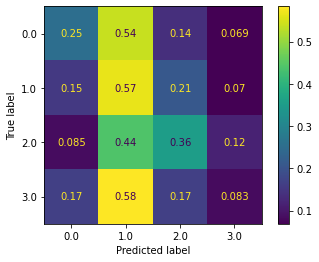

In [47]:
plot_confusion_matrix(dt_simple_model, X_test, y_test, normalize='true')

### Dog Simple Model Evaluation

Remember:

- 0 — Pet was adopted between 1 and 7 days (1st week) after being listed.
- 1 — Pet was adopted between 8 and 30 days (1st month) after being listed.
- 2 — Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
- 3 — No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).


- The model is pretty good at predicting if a dog will take longer than 100 days to adopt
- It is a little over 50 percent accurate at predicting dogs that will be adopted between 8 and 30 days
- But it is pretty bad at predicting if a dog will be adopted in the other 2 ranges

### Future Suggestion

Maybe making this a binary issue might yield better results, such as before or after 30 days possibly.

### Cat simple model

In [48]:
X = cat_model_data[used_cols]
y = cat_model_data['duration of stay']

X_train_cat, X_hold_cat, y_train_cat, y_hold_cat = train_test_split(X, y, test_size=0.15, random_state=42)

In [49]:
#perform a second train_test_split
X = X_train
y = y_train

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, random_state=42)

In [50]:
preprocessor_cat = preprocessor

In [51]:
X_tr_transformed_cat = preprocessor_cat.fit_transform(X_train_cat)
X_tr_transformed_cat.shape

(1357, 85)

Our cat training data has 1357 rows and 85 columns

In [52]:
preprocessor_cat.fit(X_train_cat)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sexname', 'basecolour', 'speciesname',
                                  'breedname', 'intakereason']),
                                ('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age(months)', 'age(years)'])])

In [53]:
cat_dt_simple_model = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', DecisionTreeClassifier())
])

In [54]:
cross_val_score(cat_dt_simple_model, X_train_cat, y_train_cat)

array([0.39338235, 0.4375    , 0.42804428, 0.44649446, 0.45387454])

In [55]:
cat_dt_simple_model.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'speciesname', 'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', DecisionTreeClassifier())])

In [56]:
cat_dt_test_preds = cat_dt_simple_model.predict(X_test_cat)
cat_dt_train_preds = cat_dt_simple_model.predict(X_train_cat)

print('test precison score', precision_score(y_test_cat, cat_dt_test_preds, average='weighted'))
print('test accuracy score', accuracy_score(y_test_cat, cat_dt_test_preds))

print('train precison score', precision_score(y_train_cat, cat_dt_train_preds, average='weighted'))
print('train accuracy score', accuracy_score(y_train_cat, cat_dt_train_preds))

test precison score 0.43366236556731297
test accuracy score 0.4481236203090508
train precison score 0.9365061070470689
train accuracy score 0.9329403095062638


Very overfit but performed 4 points better than our dog model.

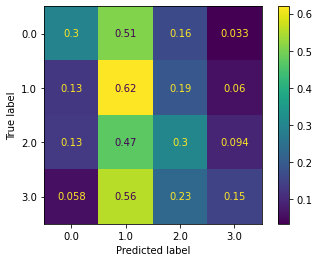

In [57]:
plot_confusion_matrix(cat_dt_simple_model, X_test_cat, y_test_cat, normalize='true')

### Simple Cat decision tree evaluation

- Performs poorly on predicting which cats that take longer than 90 days to get adopted
- Its only remotely good at predicting which cats will be adopted between 1 week and a month

#### Random forest for cat predictions

In [58]:
cat_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('classifier', RandomForestClassifier())
])

In [59]:
cross_validate(cat_forest_model, X_train_cat, y_train_cat, return_train_score=True)

{'fit_time': array([0.50714302, 0.51152658, 0.50187778, 0.51973581, 0.4927156 ]),
 'score_time': array([0.03125215, 0.01662827, 0.01562619, 0.03127861, 0.03123379]),
 'test_score': array([0.42647059, 0.5       , 0.44280443, 0.46863469, 0.51291513]),
 'train_score': array([0.93456221, 0.94654378, 0.94475138, 0.94475138, 0.94106814])}

In [60]:
cat_forest_model.fit(X_train_cat, y_train_cat)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'speciesname', 'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', RandomForestClassifier())])

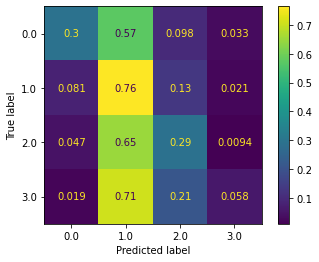

In [61]:
plot_confusion_matrix(cat_forest_model, X_test_cat, y_test_cat, normalize='true')

#### Simple Random Forest Evaluation


- While severely overfit, it performs a little better than our decision tree model on test data
- Very bad at classifying the cats that take longer than 90 days to get adopted
- Pretty good at correctly predicting which cats will be adopted between 1 week and 1 month.
- There is a class imbalance favoring 

#### Random Forest for dog predictions

In [62]:
dog_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [63]:
cross_validate(dog_forest_model, X_train, y_train, return_train_score=True)

{'fit_time': array([0.68691564, 0.67300224, 0.66818118, 0.66546583, 0.5781486 ]),
 'score_time': array([0.01562643, 0.01562691, 0.03127575, 0.03125429, 0.03125334]),
 'test_score': array([0.50276243, 0.49171271, 0.50276243, 0.48342541, 0.48895028]),
 'train_score': array([0.93646409, 0.93577348, 0.93853591, 0.9371547 , 0.94129834])}

In [64]:
dog_forest_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexname', 'basecolour',
                                                   'speciesname', 'breedname',
                                                   'intakereason']),
                                                 ('num',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age(months)',
                                                   'age(years)'])])),
                ('classifier', RandomForestClassifier())])

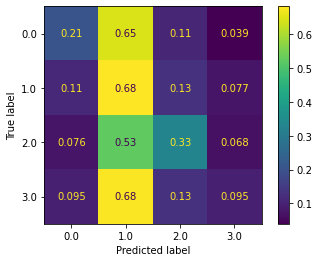

In [69]:
plot_confusion_matrix(dog_forest_model, X_test, y_test, normalize='true')

In [66]:
forest_test_preds = dog_forest_model.predict(X_test)
forest_train_preds = dog_forest_model.predict(X_train)

print('test precison score', precision_score(y_test, forest_test_preds, average='weighted'))
print('test accuracy score', accuracy_score(y_test, forest_test_preds))

print('train precison score', precision_score(y_train, forest_train_preds, average='weighted'))
print('train accuracy score', accuracy_score(y_train, forest_train_preds))

test precison score 0.413094749591985
test accuracy score 0.4519867549668874
train precison score 0.9294957551228451
train accuracy score 0.9287292817679558


- This model is 5 points better than the decision tree that we used dog predictions when evaluated on accuracy score.
- Not very good at predicting dogs that are not adopted after 90 days
- There is a class imbalance issue, I will need to oversample label '3' for better results.